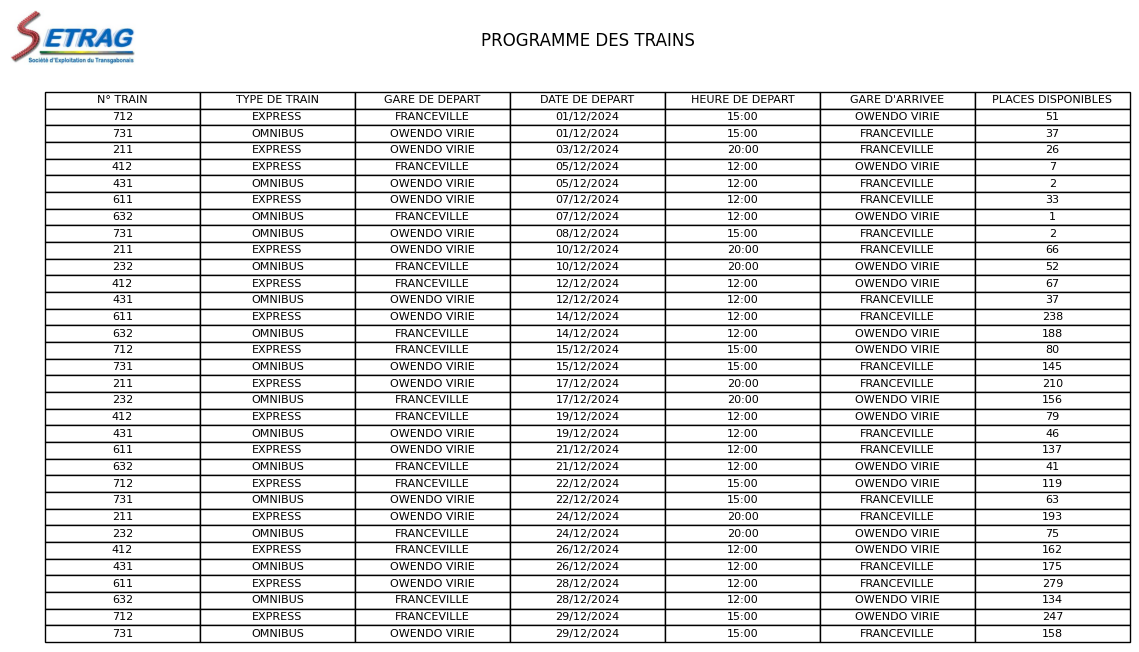

In [53]:
import pymysql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sshtunnel import SSHTunnelForwarder

# Define your SSH and MySQL credentials
ssh_host = '10.120.21.103'
ssh_port = 22
ssh_user = 'setrag'
ssh_password = 'Wabjtam,123'

mysql_host = '192.168.21.69'
mysql_port = 3306
mysql_user = 'galera'
mysql_password = 'galera'
mysql_db = 'setrag_beta1'

# Charger l'image
image_path = 'setraglogo.jpg'
img = mpimg.imread(image_path)

# Establish the SSH tunnel
with SSHTunnelForwarder(
    (ssh_host, ssh_port),
    ssh_username=ssh_user,
    ssh_password=ssh_password,
    remote_bind_address=(mysql_host, mysql_port)
) as tunnel:
    # Connect to the MySQL database
    connection = pymysql.connect(
        host='127.0.0.1',
        user=mysql_user,
        password=mysql_password,
        db=mysql_db,
        port=tunnel.local_bind_port
    )

    # Execute a query
    with connection.cursor() as cursor:
        cursor.execute("""
                        SELECT t.number AS "N° TRAIN",
                        	   tp.label AS "TYPE DE TRAIN",
                               IF(wdr.departure_station = 1, "OWENDO VIRIE", "FRANCEVILLE") AS "GARE DE DEPART",
                               DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), "%d/%m/%Y") AS "DATE DE DEPART",
                               DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), "%H:%i") AS "HEURE DE DEPART",
                               IF(wdr.arrival_station = 23, "FRANCEVILLE", "OWENDO VIRIE") AS "GARE D'ARRIVEE",
                        	   count(sbr.seat_occupation_flag) AS "PLACES DISPONIBLES"
                        FROM train AS t
                        INNER JOIN seat_booking_record AS sbr
                        ON sbr.train_id = t.id
                        INNER JOIN seat AS s
                        ON s.id = sbr.seat_id
                        INNER JOIN car AS c
                        ON c.id = s.car_id
                        INNER JOIN train_type tp
                        ON t.train_type_id = tp.id
                        INNER JOIN week_day_route  wdr
                        ON wdr.id = t.week_day_route_id
                        WHERE
                        (t.planned_date/1000) BETWEEN UNIX_TIMESTAMP('2024-12-01 00:00:00') AND UNIX_TIMESTAMP('2024-12-31 23:59:59')
                        AND sbr.seat_occupation_flag = 0 AND tp.label IN ('EXPRESS', 'OMNIBUS')
                        GROUP BY DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), "%d/%m/%Y"), t.number
        """)
        result = cursor.fetchall()
        field_names = [i[0] for i in cursor.description]
        #print(field_names)
        df = pd.DataFrame(result, columns=["N° TRAIN", "TYPE DE TRAIN", "GARE DE DEPART", "DATE DE DEPART", "HEURE DE DEPART", "GARE D'ARRIVEE", "PLACES DISPONIBLES"])
        #print(df)

        df_styled = df.style.set_table_styles(
            [{'selector': 'th', 'props': [('background-color', '#FF0000'), ('color', 'white'), ('font-weight', 'bold')]}]
        )
        

        # Plot the DataFrame as a table
        fig, ax = plt.subplots(figsize=(14, 7))
        ax.axis('tight')
        ax.axis('off')

        ax.set_title("PROGRAMME DES TRAINS", y=1.08)

        table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

        # Ajouter un nouvel axe pour le logo
        logo_ax = fig.add_axes([0.1, 0.92, 0.09, 0.085], anchor='NE', zorder=-1)
        logo_ax.imshow(img)
        logo_ax.axis('off')  # Masquer les axes du logo
        
        # Save the table as a JPEG image
        plt.savefig('data_table.jpg', format='jpeg')

    # Close the connection
    connection.close()